<a href="https://colab.research.google.com/github/dunnohow/LSTM_Autoencoder/blob/master/Flight_seq2seq_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [4]:
device = torch.device("cuda")

<br>

# Loading Data

In [5]:
#sns.get_dataset_names()

In [6]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


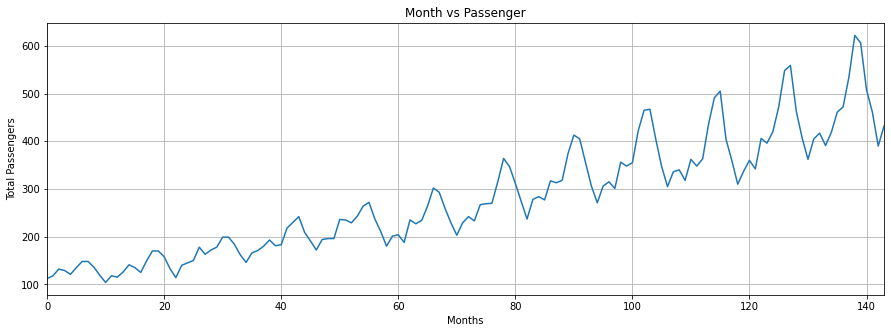

In [7]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

In [8]:
all_data = flight_data['passengers'].values.astype(float)

In [9]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_data.reshape(-1, 1))
train_data_normalized = scaler.transform(train_data.reshape(-1, 1))
test_data_normalized = scaler.transform(test_data.reshape(-1, 1))

In [11]:
train_window = 12

<br>

#For LSTM

In [ ]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [ ]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [ ]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

<br>

#For Autoencoder

In [12]:
def create_dataset(df):
  sequences = df.astype(np.float32).tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

In [13]:
train_data_normalized.reshape(-1,12).shape

(11, 12)

In [14]:
train_data, seq_len, n_features = create_dataset(train_data_normalized.reshape(-1,12))

In [15]:
train_loader = DataLoader(train_data, batch_size = 1, shuffle = False)

In [16]:
next(iter(train_loader)).shape

torch.Size([1, 12, 1])

In [17]:
epochs = 3000

<br>
<br>

# LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, (hidden_out, cell_out) = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        print(lstm_out)
        print(hidden_out)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        #print(predictions.shape)
        return predictions[-1]

In [ ]:
model = LSTM()
model = model.cuda()
loss_function = nn.L1Loss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

KeyboardInterrupt: ignored

In [ ]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).cuda(),
                        torch.zeros(1, 1, model.hidden_layer_size).cuda())
        seq = seq.cuda()
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels.cuda())
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

In [ ]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(len(test_inputs))

In [ ]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:]).cuda()
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).cuda(),
                        torch.zeros(1, 1, model.hidden_layer_size).cuda())
        test_inputs.append(model(seq).item())

In [ ]:
seq = torch.FloatTensor(test_inputs[-train_window:]).cuda()
model(seq).item()

In [ ]:
test_inputs[fut_pred:]

In [ ]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

In [ ]:
flight_data['passengers'][-train_window:]

In [ ]:
plt.plot(flight_data['passengers'][-train_window:].reset_index(drop = True), color = 'blue')
plt.plot(actual_predictions, color = 'green')
plt.show()

<br>

# LSTM Autoencoder Hidden

In [56]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
        y = self.module(x_reshape)
        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)
        return y

In [97]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim // 2,
      num_layers=1,
      batch_first=True,
      bidirectional = True # Doubles the hidden_dim
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True,
      bidirectional = False
    )

  def forward(self, x):

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [98]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)
    self.timedist = TimeDistributed(self.output_layer, batch_first=True)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim)) # Since batch size is equal to 1, sqeueeze it into (12, hidden_dim)
    return self.timedist(x)

In [99]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).cuda()
    self.decoder = Decoder(seq_len, embedding_dim, n_features).cuda()

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [102]:
model1 = RecurrentAutoencoder(seq_len, n_features, 128)
model1 = model1.cuda()
model1

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 128, batch_first=True, bidirectional=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
    (timedist): TimeDistributed(
      (module): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)

In [103]:
def train_model(model, train_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').cuda()
    history = dict(train=[])

    for epoch in range(n_epochs):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.float().cuda()
            seq_pred = model(seq_true)

            loss = criterion(seq_pred.reshape(1,-1,1), seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        train_loss = np.mean(train_losses)

        history['train'].append(train_loss)

        best_model_wts = copy.deepcopy(model.state_dict())
        if (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1}: train loss {train_loss}')

    model.load_state_dict(best_model_wts)

    plt.rcParams["figure.figsize"] = (10,6)
    ax = plt.figure().gca()
    ax.plot(history['train'])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss over training epochs')
    plt.show()
    return model.eval(), history

Epoch 100: train loss 1.0862641280347651
Epoch 200: train loss 0.3576795350421559
Epoch 300: train loss 0.3819671747359363
Epoch 400: train loss 0.5126860656521537
Epoch 500: train loss 0.2432935034686869
Epoch 600: train loss 0.3876476585865021
Epoch 700: train loss 0.21172707324678247
Epoch 800: train loss 0.18041724440726367
Epoch 900: train loss 0.18619934943589297
Epoch 1000: train loss 0.19935372945937244
Epoch 1100: train loss 0.21482978016138077
Epoch 1200: train loss 0.13173974440856415
Epoch 1300: train loss 0.16206579045815903
Epoch 1400: train loss 0.1550333107059652
Epoch 1500: train loss 0.10021040893413803
Epoch 1600: train loss 0.08277955177155408
Epoch 1700: train loss 0.0794247906993736
Epoch 1800: train loss 0.08645255050875923
Epoch 1900: train loss 0.11122927205129103
Epoch 2000: train loss 0.09222348508509723
Epoch 2100: train loss 0.08034094677052715
Epoch 2200: train loss 0.07172229784456166
Epoch 2300: train loss 0.09057179635221307
Epoch 2400: train loss 0.113

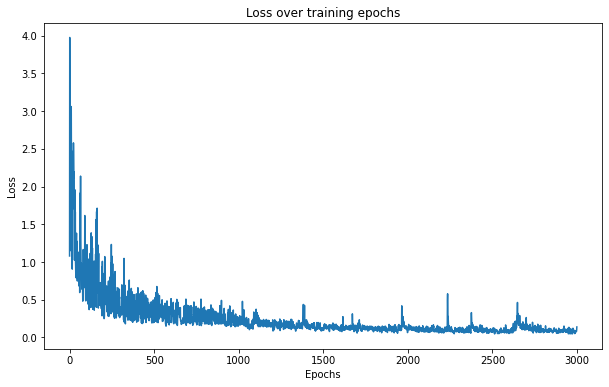

In [104]:
model, history = train_model(model1, train_loader, 3000)

In [105]:
def predict_test(data, model, scaler):
    temp_model = model.eval()
    row = torch.from_numpy(data).float()
    yhat = temp_model(row.cuda())
    yhat = yhat.cpu().detach().numpy()
    yhat = scaler.inverse_transform(yhat).reshape(-1,1)
    pred = pd.DataFrame(np.concatenate((yhat, data.reshape(-1,1)), axis = 1), columns = ['yhat','actual'])

    return(pred)

In [106]:
pred = predict_test(test_data.reshape(1,-1,1), model, scaler)
print(pred)

          yhat  actual
0   361.182465   417.0
1   343.117065   391.0
2   410.243286   419.0
3   400.287842   461.0
4   421.201233   472.0
5   471.742645   535.0
6   552.508057   622.0
7   569.041687   606.0
8   470.060516   508.0
9   412.600739   461.0
10  370.754395   390.0
11  410.772400   432.0


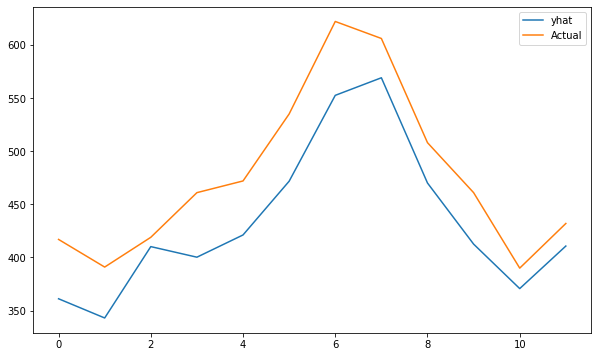

In [107]:
plt.plot(pred.iloc[:,0], label = 'yhat')
plt.plot(pred.iloc[:,1], label = 'Actual')
plt.legend()
plt.show()

<br>

# LSTM Autoencoder Output

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return x

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).cuda()
    self.decoder = Decoder(seq_len, embedding_dim, n_features).cuda()

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
model1 = RecurrentAutoencoder(seq_len, n_features, 128)
model1 = model1.cuda()

In [ ]:
def train_model(model, train_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').cuda()
    history = dict(train=[])

    for epoch in range(n_epochs):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.float().cuda()
            seq_pred = model(seq_true)

            loss = criterion(seq_pred.reshape(1,-1,1), seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        train_loss = np.mean(train_losses)

        history['train'].append(train_loss)

        best_model_wts = copy.deepcopy(model.state_dict())
        if (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1}: train loss {train_loss}')

    model.load_state_dict(best_model_wts)

    plt.rcParams["figure.figsize"] = (10,6)
    ax = plt.figure().gca()
    ax.plot(history['train'])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss over training epochs')
    plt.show()
    return model.eval(), history

Epoch 100: train loss 1.1894049590284175
Epoch 200: train loss 0.49564346129244025
Epoch 300: train loss 0.32824489067901264
Epoch 400: train loss 0.1444847218014977
Epoch 500: train loss 0.19846994091163983
Epoch 600: train loss 0.42036549069664697
Epoch 700: train loss 0.1743725524707274
Epoch 800: train loss 0.17804547873410312
Epoch 900: train loss 0.14581651443784888
Epoch 1000: train loss 0.22408940880136055
Epoch 1100: train loss 0.08691675690087405
Epoch 1200: train loss 0.15175152637741782
Epoch 1300: train loss 0.13453213091601024
Epoch 1400: train loss 0.13232725858688354
Epoch 1500: train loss 0.28145838190208783
Epoch 1600: train loss 0.07597119225697084
Epoch 1700: train loss 0.10059983621944081
Epoch 1800: train loss 0.18991729617118835
Epoch 1900: train loss 0.11682614277709615
Epoch 2000: train loss 0.17852431942116131
Epoch 2100: train loss 0.21822915497151288
Epoch 2200: train loss 0.19206245108084244
Epoch 2300: train loss 0.12916023216464304
Epoch 2400: train loss 

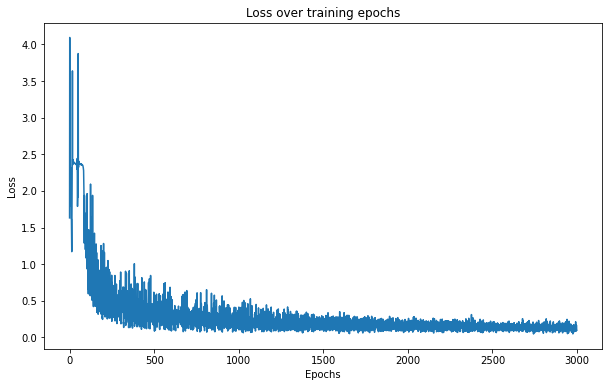

In [ ]:
model, history = train_model(model1, train_loader, 3000)

In [ ]:
def predict_test(data, model, scaler):
    temp_model = model.eval()
    row = torch.from_numpy(data).float()
    yhat = temp_model(row.cuda())
    yhat = yhat.cpu().detach().numpy()
    yhat = scaler.inverse_transform(yhat).reshape(-1,1)
    pred = pd.DataFrame(np.concatenate((yhat, data.reshape(-1,1)), axis = 1), columns = ['yhat','actual'])

    return(pred)

In [ ]:
pred = predict_test(test_data.reshape(1,-1,1), model, scaler)
print(pred)

          yhat  actual
0   583.936340   417.0
1   596.259827   391.0
2   628.309265   419.0
3   636.129639   461.0
4   639.977600   472.0
5   644.328735   535.0
6   648.339417   622.0
7   652.030823   606.0
8   655.573242   508.0
9   658.717590   461.0
10  661.467590   390.0
11  663.752502   432.0


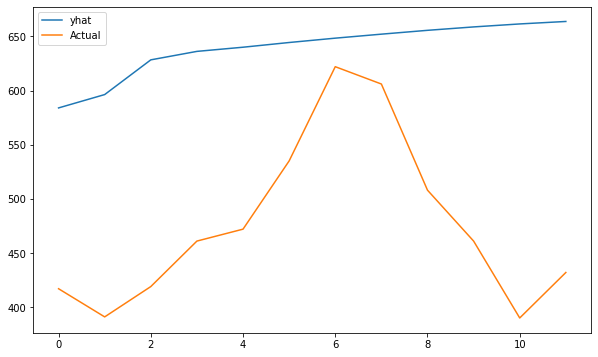

In [ ]:
plt.plot(pred.iloc[:,0], label = 'yhat')
plt.plot(pred.iloc[:,1], label = 'Actual')
plt.legend()
plt.show()

<br>

# GRU Autoencoder Output

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.GRU(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.GRU(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):

    x, _ = self.rnn1(x)
    x, hidden_n = self.rnn2(x)

    return x

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.GRU(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.GRU(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, hidden_n = self.rnn1(x)
    x, hidden_n = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).cuda()
    self.decoder = Decoder(seq_len, embedding_dim, n_features).cuda()

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
model1 = RecurrentAutoencoder(seq_len, n_features, 128)
model1 = model1.cuda()

In [ ]:
def train_model(model, train_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').cuda()
    history = dict(train=[])

    for epoch in range(n_epochs):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.float().cuda()
            seq_pred = model(seq_true)

            loss = criterion(seq_pred.reshape(1,-1,1), seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        train_loss = np.mean(train_losses)

        history['train'].append(train_loss)

        best_model_wts = copy.deepcopy(model.state_dict())
        if (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1}: train loss {train_loss}')

    model.load_state_dict(best_model_wts)

    plt.rcParams["figure.figsize"] = (10,6)
    ax = plt.figure().gca()
    ax.plot(history['train'])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss over training epochs')
    plt.show()
    return model.eval(), history

Epoch 100: train loss 0.4075147401202809
Epoch 200: train loss 0.22790393097834152
Epoch 300: train loss 0.7597084451805461
Epoch 400: train loss 0.2837709147821773
Epoch 500: train loss 0.6552453095262701
Epoch 600: train loss 0.1803408685055646
Epoch 700: train loss 0.26469704508781433
Epoch 800: train loss 0.598628892139955
Epoch 900: train loss 0.5220143469897184
Epoch 1000: train loss 0.35145224359902466
Epoch 1100: train loss 0.19917256452820517
Epoch 1200: train loss 0.351372092962265
Epoch 1300: train loss 0.27162238549102435
Epoch 1400: train loss 0.11398573219776154
Epoch 1500: train loss 0.13901634243401614
Epoch 1600: train loss 0.18559967489405113
Epoch 1700: train loss 0.2397690456021916
Epoch 1800: train loss 0.17466179484670813
Epoch 1900: train loss 0.11627889356829903
Epoch 2000: train loss 0.11594020507552406
Epoch 2100: train loss 0.11196144331585277
Epoch 2200: train loss 0.15306302160024643
Epoch 2300: train loss 0.11003267019987106
Epoch 2400: train loss 0.120918

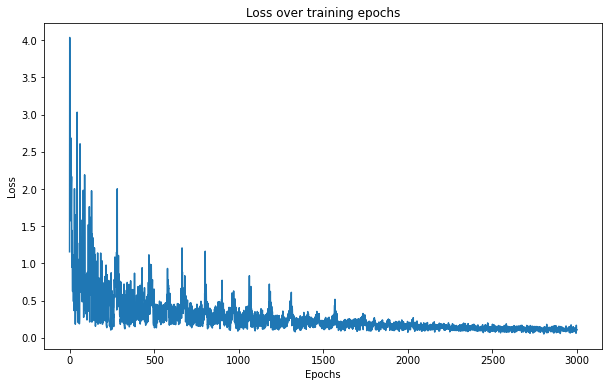

In [ ]:
model, history = train_model(model1, train_loader, 3000)

In [ ]:
def predict_test(data, model, scaler):
    temp_model = model.eval()
    row = torch.from_numpy(data).float()
    yhat = temp_model(row.cuda())
    yhat = yhat.cpu().detach().numpy()
    yhat = scaler.inverse_transform(yhat).reshape(-1,1)
    pred = pd.DataFrame(np.concatenate((yhat, data.reshape(-1,1)), axis = 1), columns = ['yhat','actual'])

    return(pred)

In [ ]:
pred = predict_test(test_data.reshape(1,-1,1), model, scaler)
print(pred)

          yhat  actual
0   623.056641   417.0
1   524.932007   391.0
2   459.529755   419.0
3   438.997650   461.0
4   613.207642   472.0
5   689.779053   535.0
6   592.548889   622.0
7   572.902832   606.0
8   540.143677   508.0
9   672.431824   461.0
10  549.712158   390.0
11  547.344116   432.0


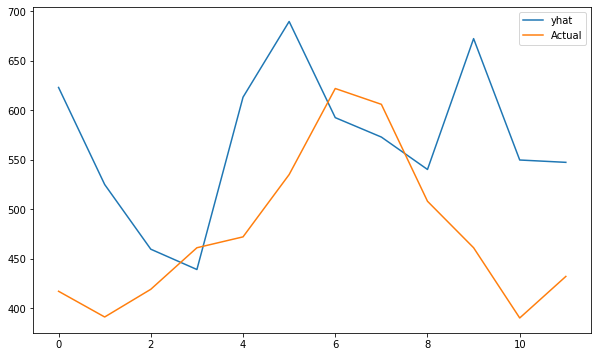

In [ ]:
plt.plot(pred.iloc[:,0], label = 'yhat')
plt.plot(pred.iloc[:,1], label = 'Actual')
plt.legend()
plt.show()

<br>

# GRU Autoencoder Hidden

In [68]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
        y = self.module(x_reshape)
        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)
        return y

In [88]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.GRU(
      input_size=n_features,
      hidden_size=self.hidden_dim // 2, # Bidirectional will double this dimension size 
      num_layers=1,
      batch_first=True,
      bidirectional = True
    )

    self.rnn2 = nn.GRU(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):

    x, _ = self.rnn1(x)
    x, hidden_n = self.rnn2(x)
    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [89]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.GRU(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True 
    )

    self.rnn2 = nn.GRU(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)
    self.timedist = TimeDistributed(self.output_layer)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, _ = self.rnn1(x)
    x, _ = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.timedist(x)

In [90]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).cuda()
    self.decoder = Decoder(seq_len, embedding_dim, n_features).cuda()

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [91]:
model1 = RecurrentAutoencoder(seq_len, n_features, 64)
model1 = model1.cuda()
model1

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): GRU(1, 64, batch_first=True, bidirectional=True)
    (rnn2): GRU(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): GRU(64, 64, batch_first=True)
    (rnn2): GRU(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
    (timedist): TimeDistributed(
      (module): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [92]:
def train_model(model, train_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').cuda()
    history = dict(train=[])

    for epoch in range(n_epochs):
        model = model.train()

        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.float().cuda()
            seq_pred = model(seq_true)

            loss = criterion(seq_pred.reshape(1,-1,1), seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        train_loss = np.mean(train_losses)

        history['train'].append(train_loss)

        best_model_wts = copy.deepcopy(model.state_dict())
        if (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1}: train loss {train_loss}')

    model.load_state_dict(best_model_wts)

    plt.rcParams["figure.figsize"] = (10,6)
    ax = plt.figure().gca()
    ax.plot(history['train'])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss over training epochs')
    plt.show()
    return model.eval(), history

Epoch 100: train loss 1.097280421040275
Epoch 200: train loss 0.3688692098314112
Epoch 300: train loss 0.5005883791229941
Epoch 400: train loss 0.4327593825080178
Epoch 500: train loss 0.1751724420623346
Epoch 600: train loss 0.36428718946196814
Epoch 700: train loss 0.2631590569561178
Epoch 800: train loss 0.3126449693333019
Epoch 900: train loss 0.2448304837400263
Epoch 1000: train loss 0.2337399341843345
Epoch 1100: train loss 0.2966229712421244
Epoch 1200: train loss 0.19876207546754318
Epoch 1300: train loss 0.23599895631725137
Epoch 1400: train loss 0.16751580143516714
Epoch 1500: train loss 0.13821154697374863
Epoch 1600: train loss 0.17965203794566068
Epoch 1700: train loss 0.19296438721093265
Epoch 1800: train loss 0.153555459596894
Epoch 1900: train loss 0.14929735660552979
Epoch 2000: train loss 0.1019280505451289
Epoch 2100: train loss 0.08576504750685258
Epoch 2200: train loss 0.10265220295299184
Epoch 2300: train loss 0.10857315022837032
Epoch 2400: train loss 0.140468247

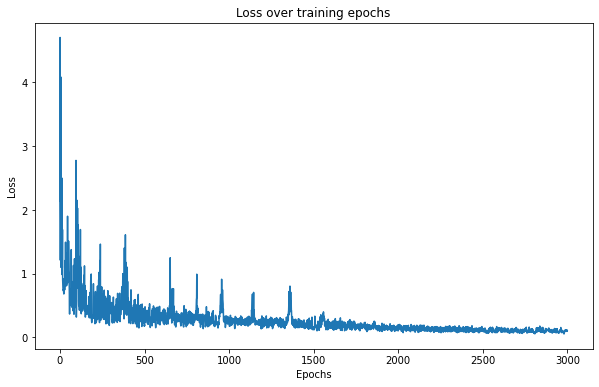

In [93]:
model, history = train_model(model1, train_loader, 3000)

In [94]:
def predict_test(data, model, scaler):
    temp_model = model.eval()
    row = torch.from_numpy(data).float()
    yhat = temp_model(row.cuda())
    yhat = yhat.cpu().detach().numpy()
    yhat = scaler.inverse_transform(yhat).reshape(-1,1)
    pred = pd.DataFrame(np.concatenate((yhat, data.reshape(-1,1)), axis = 1), columns = ['yhat','actual'])

    return(pred)

In [95]:
pred = predict_test(test_data.reshape(1,-1,1), model, scaler)
print(pred)

          yhat  actual
0   342.177490   417.0
1   302.870148   391.0
2   353.250031   419.0
3   337.124451   461.0
4   400.316315   472.0
5   470.684631   535.0
6   539.604431   622.0
7   479.346649   606.0
8   363.219177   508.0
9   375.736816   461.0
10  416.987152   390.0
11  481.708221   432.0


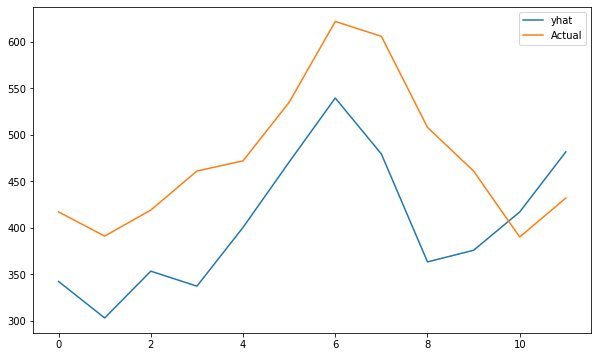

In [96]:
plt.plot(pred.iloc[:,0], label = 'yhat')
plt.plot(pred.iloc[:,1], label = 'Actual')
plt.legend()
plt.show()